In [14]:
pip install pandas numpy matplotlib seaborn --upgrade scipy

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install dash dash-core-components dash-html-components dash-table plotly

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install dash dash-renderer dash-html-components dash-core-components plotly

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install dash dash-bootstrap-components dash-table

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install dash dash-bootstrap-components dash-table

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install dash plotly

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install dash dash-bootstrap-components pandas

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [22]:
### import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import plotly.express as px
from tabulate import tabulate 
import plotly.graph_objs as go
from dash import Dash, dcc, html
from IPython.display import display, HTML, Markdown
import warnings


In [23]:
def load_survey_data(filename):
    try:
        return pd.read_excel(filename, header=0)
    except FileNotFoundError:
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

In [24]:
def preprocess_data(data, num_personal_info_cols, choice, categorical_mappings):
    if num_personal_info_cols >= data.shape[1]:
        raise ValueError("Number of personal info columns exceeds total columns.")
        
    if choice == 1:
        data = data.dropna()
    elif choice == 2:
        for column in data.columns[num_personal_info_cols:]:
            if data[column].dtype == 'object':
                data[column].fillna(data[column].mode()[0], inplace=True)
            else:
                data[column].fillna(data[column].mean(), inplace=True)
    elif choice == 3:
        fill_value = input("Enter the value to fill missing data with: ")
        data = data.fillna(fill_value)

    # Convert non-numeric responses if present
    if categorical_mappings:
        for column in data.columns:
            if data[column].dtype == 'object':
                data[column] = data[column].map(categorical_mappings).fillna(data[column])

    return data

In [25]:
def display_categorical_mappings(data, num_personal_info_cols):
    non_numeric_responses = set()

    # Check each column for non-numeric responses
    for column in data.columns[num_personal_info_cols:]:
        if data[column].dtype == 'object':
            non_numeric_responses.update(data[column].unique())

    # Proceed only if there are non-numeric responses
    if non_numeric_responses:
        display(HTML("<h2 style='color:green; font-weight:bold;'>NON-NUMERIC RESPONSES CONVERSIONS:</h3>"))
        non_numeric_responses_str = ', '.join(f'<u><b>{response}</b></u>' for response in non_numeric_responses)  # Format each response

        # Display the instruction, non-numeric responses, and the example conversion table
        instruction_html = f"""
        <b>\nINSTRUCTION:</b> Based on checking, your survey contains non-numeric responses: {non_numeric_responses_str}<br>
        <p>Please convert these non-numeric responses into numeric values so that the system can calculate them.</p>
        <h4 style='color:green; font-weight:bold;'>Non-numeric Response Conversion Table Example:</h3>
        """
        display(HTML(instruction_html))

        # Example data for non-numeric response conversion
        example_mapping_data = [
            ['Very Satisfied', 4],
            ['Satisfied', 3],
            ['Dissatisfied', 2],
            ['Very Dissatisfied', 1]
        ]

        # Generate an HTML table from the example data
        html_table = tabulate(example_mapping_data, headers=['Non-numeric', 'Numeric Equivalent'], tablefmt='html')
        display(HTML(html_table))

        # Ask the user to input mappings
        mapping_data = []
        for response in non_numeric_responses:
            while True:
                display(HTML(f"<p>Please enter the numeric value for <u><b>{response}</b></u>:</p>"))
                try:
                    numeric_value = int(input())
                    if numeric_value > 0:
                        mapping_data.append([response, numeric_value])
                        break  # Exit the loop if a valid input is provided
                    else:
                        raise ValueError("<font color='red'><b>Error:</b></font> Please enter a numeric value greater than 0.")
                except ValueError as e:
                    display(Markdown(f"<font color='red'><b>Error:</b> Invalid input. Please enter a valid numeric value greater than 0.</font>"))

        # Now you can create the dictionary from the mapping_data
        result_dict = {response: value for response, value in mapping_data}

        return result_dict

    
    # If no non-numeric responses are found, an empty dictionary is returned
    return {}

In [26]:
def display_menu():
    menu = """
    <h2 style='color:green; font-weight:bold;'>PROGRAM CAPABILITIES</h2>
    <p><b>1. DEMOGRAPHICS OF THE RESPONDENTS</b></p>
    <p>- Create an interactive table displaying demographics data for respondents, including age, gender, and location. Show measures, frequency, and percentages.</p>
    <p><b>2. CATEGORY/FACTOR ANALYSIS</b></p>
    <p>- Analyze questions that measure a single factor or category. Provide the titles and questions under each factor/category as an example.</p>
    <p><b>3. CORRELATIONAL ANALYSIS</b></p>
    <p>- Investigate the presence of positive relationships between survey questions and between factors/categories. Generate a heatmap and highlight the top 3 strong positive relationships.</p>
    <p><b>4. SIGNIFICANT DIFFERENCES BETWEEN DATAS</b></p>
    <p>- Examine if there are significant differences between respondent demographics and their responses within each factor/category. <i>This analysis should only be conducted after completing the category/factor analysis (Capability No.2).</i></p>
    <p><b>5. INDIVIDUAL ANALYSIS FOR ALL QUESTIONS</b></p>
    <p>- Perform an individual analysis of all survey questions, presenting them with interactive charts for comprehensive insights.\n</p>
    """
    # Display the menu
    display(HTML(menu))

    # Get user's selection
    while True:
        display(HTML("<font style='font-family:Arial;'><b>\nSelect the analysis you want to perform (e.g., '1' for Profile of the Respondents, '1,2,3' for multiple analyses, or 'all' for all analyses):</b></font> "))
        selected_analysis = input().lower()

        try:
            if selected_analysis == 'all' or all(char.isdigit() and 1 <= int(char) <= 5 or char == ',' for char in selected_analysis.split(',')):
                # Check if '4' is selected without '2'
                selected_numbers = [int(char) for char in selected_analysis.split(',') if char.isdigit()]
                if 4 in selected_numbers and 2 not in selected_numbers:
                     raise ValueError("\n<font color='red'><b>Error:</b><b> You cannot select '4' without selecting '2'.</font></b>")
                else:
                    return selected_analysis
            else:
                raise ValueError("\n<font color='red'><b>Error:</b><b> Invalid input. Please enter a digit from 1 to 5, digits from 1 to 5 separated by a comma, or 'all'.\nExample: '1', '2,3', 'all'.</font></b>")
        except ValueError as e:
            display(Markdown(str(e)))

In [27]:
def display_analysis_heading(title):
    # Generate an HTML heading for analysis
    analysis_heading = f"<h2 style='color: green; font-weight: bold;'>{title}</h2>"
    
    # Display the HTML heading
    display(HTML(analysis_heading))

def display_title(title):
    # Display the title of the program
    console_width = 140
    print(title.center(console_width), "\n")

In [28]:
def analyze_personal_info(data, num_personal_info_cols):
    profile_analysis = {}
    for column in data.columns[:num_personal_info_cols]:
        counts = data[column].value_counts()
        total = len(data[column])
        percentages = (counts / total * 100).round(0).astype(int)
        profile_analysis[column] = pd.DataFrame({
            'Measure': counts.index,
            'Frequency': counts.values,
            'Percentage': percentages.astype(str) + '%'
        })
    return profile_analysis


def interpret_verbal(mean, reverse_mapping):
    mean_rounded = round(mean)
    return reverse_mapping.get(mean_rounded, "No interpretation available")

In [29]:
def display_profile_table(profile_analysis, data):
    # Display Dash DataTable for profile analysis
    app = dash.Dash(__name__)

    app.layout = html.Div([
        html.Div([
            dcc.Dropdown(
                id='profile-dropdown',
                options=[{'label': column, 'value': column} for column in profile_analysis.keys()],
                value=list(profile_analysis.keys())[0]
            ),
            dash_table.DataTable(
                id='profile-table',
                columns=[
                    {'name': 'Measure', 'id': 'Measure'},
                    {'name': 'Frequency', 'id': 'Frequency'},
                    {'name': 'Percentage', 'id': 'Percentage'}
                ],
                style_table={'overflowX': 'auto'},
                style_cell={'minWidth': 95},
            ),
            html.Div([
                dcc.Graph(id='profile-pie-chart', style={'height': '350px', 'width': '800px'})
            ], style={'display': 'flex', 'justify-content': 'center'}),  # Center the pie chart
            html.Div(id='verbal-interpretation', style={'color': 'black', 'text-align': 'center', 'font-weight': 'bold'})
        ]),
    ])

    @app.callback(
        [Output('profile-table', 'data'), Output('verbal-interpretation', 'children'), Output('profile-pie-chart', 'figure')],
        [Input('profile-dropdown', 'value')]
    )
    def update_table(selected_column):
        df = profile_analysis[selected_column]

        # Find the response with the highest percentage
        highest_percentage_row = df[df['Percentage'] == df['Percentage'].max()]
        highest_percentage_response = highest_percentage_row.iloc[0]['Measure']
        highest_percentage = highest_percentage_row.iloc[0]['Percentage']

        # Find the response with the lowest percentage
        lowest_percentage_row = df[df['Percentage'] == df['Percentage'].min()]
        lowest_percentage_response = lowest_percentage_row.iloc[0]['Measure']
        lowest_percentage = lowest_percentage_row.iloc[0]['Percentage']

        # Create the verbal interpretation
        verbal_interpretation = html.Div([
            html.H3(f"VERBAL INTERPRETATION [Demographic 1 : {selected_column}]", style={'color': 'green', 'text-align': 'center', 'font-weight': 'bold'}),
            html.P(f"\nAccording to the result of '{selected_column}' demographics, '{highest_percentage_response}' has the highest number of respondents with {highest_percentage} while the lowest is '{lowest_percentage_response}' with {lowest_percentage}"),
        ])

        # Create pie chart
        fig = px.pie(df, values='Frequency', names='Measure', title=f'{selected_column} Distribution')

        return df.to_dict('records'), verbal_interpretation, fig

    app.run_server(port=8050, use_reloader=False)

In [30]:
def analyze_category(data, categories, num_personal_info_cols, reverse_categorical_mappings):
    category_analysis = {}
    overall_analysis = []
    overall_n = []
    for category, questions in categories.items():
        valid_questions = [q for q in questions if q in data.columns[num_personal_info_cols:]]
        if not valid_questions:
            print(f"Warning: No valid questions found for category '{category}'. Skipping this category.")
            continue

        category_data = data[valid_questions]
        n = len(category_data)
        mean = category_data.mean(numeric_only=True)
        std_dev = category_data.std(numeric_only=True)

        # Creating a list for the category analysis
        analysis_data = []
        
        #For each question and overall category
        for question in valid_questions:
            interpretation = interpret_verbal(mean[question], reverse_categorical_mappings)
            analysis_data.append([question, n, f"{mean[question]:.2f}", f"{std_dev[question]:.2f}", interpretation])

        # Calculate category averages
        total_mean = mean.mean()
        total_std_dev = std_dev.mean()
        total_interpretation = interpret_verbal(total_mean, reverse_categorical_mappings)
        analysis_data.append([f"{category} OVERALL", n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])
        category_analysis[category] = analysis_data

        # Collect data for overall analysis
        overall_n.append(n)
        if analysis_data:
            overall_analysis.append([category, n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

    # Add overall row in overall analysis
    if overall_analysis:
        overall_avg_n = np.mean(overall_n)
        overall_means = np.mean([float(row[2]) for row in overall_analysis])
        overall_stdevs = np.mean([float(row[3]) for row in overall_analysis])
        overall_interpretation = interpret_verbal(overall_means, reverse_categorical_mappings)
        overall_analysis.append(["OVERALL", overall_avg_n, f"{overall_means:.2f}", f"{overall_stdevs:.2f}", overall_interpretation])

    return category_analysis, overall_analysis

In [31]:
def display_category_analysis(category_analysis, overall_analysis, data):
    app = Dash(__name__)

    # Define the layout
    app.layout = html.Div([
        html.Div([
            dcc.Dropdown(
                id='category-dropdown',
                options=[{'label': category, 'value': category} for category in category_analysis.keys()],
                value=list(category_analysis.keys())[0]
            ),
            dash_table.DataTable(
                id='category-table',
                columns=[
                    {'name': 'Question', 'id': 'Question'},
                    {'name': 'N', 'id': 'N'},
                    {'name': 'Mean', 'id': 'Mean'},
                    {'name': 'Std Dev', 'id': 'Std Dev'},
                    {'name': 'Interpretation', 'id': 'Interpretation'}
                ],
                style_table={'overflowX': 'auto'},
                style_cell={'minWidth': 95},
            )
        ]),
        html.Div(
            id='verbal-interpretation',
            style={
                'margin': 'auto',
                'text-align': 'center',
            }
        )
    ])

    # Define the callback
    @app.callback(
        [Output('category-table', 'data'), Output('verbal-interpretation', 'children')],
        [Input('category-dropdown', 'value')]
    )
    def update_category_table(selected_category):
        df = pd.DataFrame(category_analysis[selected_category], columns=['Question', 'N', 'Mean', 'Std Dev', 'Interpretation'])

        # Find highest and lowest mean scores
        highest = df.iloc[df['Mean'].idxmax()]
        lowest = df.iloc[df['Mean'].idxmin()]

        # Overall assessment for the category
        overall_mean = df['Mean'].astype(float).mean()
        overall_assessment = mean_to_category(overall_mean)

        # Prepare verbal interpretation content
        
        interpretation_content = html.Div([
            # If you need to display the selected question, define `selected_question` appropriately
            html.H3("VERBAL INTERPRETATION", style={'color': 'green', 'text-align': 'center', 'font-weight': 'bold'}),
            html.Center(html.P(f"In '{selected_category}', the highest scoring question is '{highest['Question']}' with a mean score of {highest['Mean']} ({highest['Interpretation']}), while the lowest is '{lowest['Question']}' with a score of {lowest['Mean']} ({lowest['Interpretation']}),", style={'font-weight': 'bold'})),
            html.Center(html.P(f"Overall, this category rates as {overall_assessment} with an average score of {overall_mean:.2f},", style={'font-weight': 'bold'}))
        ])

        return df.to_dict('records'), interpretation_content

    # Additional layout elements for overall analysis
    if overall_analysis:
        overall_df = pd.DataFrame(overall_analysis, columns=['Category', 'N', 'Mean', 'Std Dev', 'Interpretation'])

        # Modify the last row's category to "OVERALL"
        if not overall_df.empty:
            overall_df.at[len(overall_df) - 1, 'Category'] = "OVERALL"

        # Create Overall Analysis Table
        overall_table = dash_table.DataTable(
            id='overall-table',
            columns=[
                {'name': 'Category', 'id': 'Category'},
                {'name': 'N', 'id': 'N'},
                {'name': 'Mean', 'id': 'Mean'},
                {'name': 'Std Dev', 'id': 'Std Dev'},
                {'name': 'Interpretation', 'id': 'Interpretation'}
            ],
            data=overall_df.to_dict('records'),
            style_table={'overflowX': 'auto'},
            style_cell={'minWidth': 95},
        )

        # Find highest and lowest mean scores across all categories
        highest = overall_df.iloc[overall_df['Mean'].astype(float).idxmax()]
        lowest = overall_df.iloc[overall_df['Mean'].astype(float).idxmin()]

        # Overall assessment for the overall analysis
        overall_mean = overall_df['Mean'].astype(float).mean()
        overall_assessment = mean_to_category(overall_mean)

        # Prepare verbal interpretation content for overall analysis
        overall_interpretation_content = html.Div([
            html.H3("OVERALL VERBAL INTERPRETATION", style={'color': 'green', 'text-align': 'center', 'font-weight': 'bold'}),
            html.Center(html.P(f"In the overall analysis, the highest scoring category is '{highest['Category']}' with a mean score of {highest['Mean']} ({highest['Interpretation']}), while the lowest is '{lowest['Category']}' with a score of {lowest['Mean']} ({lowest['Interpretation']}),", style={'font-weight': 'bold'})),
            html.Center(html.P(f"Overall, the analysis rates as {overall_assessment} with an average score of {overall_mean:.2f},", style={'font-weight': 'bold'}))
        ])


        app.layout.children.append(html.Div([html.H3('Overall Analysis'), overall_table, overall_interpretation_content]))

    # Run the server
    app.run_server(port=8051, use_reloader=False)

In [32]:
def interpret_verbal(mean, reverse_mapping):
    mean_rounded = round(mean)
    return reverse_mapping.get(mean_rounded, "No interpretation available")

In [33]:
def mean_to_category(mean_value):
    if mean_value >= 4:
        return 'Very High'
    elif mean_value >= 3:
        return 'High'
    elif mean_value >= 2:
        return 'Medium'
    else:
        return 'Low'

In [34]:
def convert_categorical_to_numeric(data, categories):
    converted_data = data.copy()
    for category, mappings in categories.items():
        if category in converted_data.columns:
            converted_data[category] = converted_data[category].map(mappings)
    return converted_data

In [35]:
def display_combined_correlation_heatmaps(cleaned_data, num_personal_info_cols, categories):
    # Set font style with Times New Roman
    font_style = {'family': 'serif', 'weight': 'bold', 'fontname': 'Times New Roman'}

    # Heatmap for Individual Questions
    survey_questions_data = cleaned_data.iloc[:, num_personal_info_cols:]
    corr_matrix_questions = survey_questions_data.corr()
    plt.figure(figsize=(12, 8))
    
    # Use a green colormap for the heatmap
    ax1 = sns.heatmap(corr_matrix_questions, annot=True, cmap='YlGnBu', fmt=".2f", cbar=False)
    ax1.set_title("Individual Question Correlation Heatmap", fontdict=font_style)
    
    # Numbering format for x-axis labels
    x_labels = [f'Q{i}' for i in range(1, len(corr_matrix_questions.columns) + 1)]
    ax1.set_xticklabels(x_labels, rotation=90, va="center", position=(0, -0.05))
    
    # Numbering format for y-axis labels
    y_labels = [f'Q{i}' for i in range(1, len(corr_matrix_questions.columns) + 1)]
    ax1.set_yticklabels(y_labels, rotation=0)
    
    ax1.xaxis.tick_top()  # Move x-axis labels to top
    plt.show()

    # Displaying verbal interpretation for Individual Questions
    display_top_relationships(corr_matrix_questions)

    # Heatmap for Categories
    category_data = pd.DataFrame()
    for category, questions in categories.items():
        category_data[category] = cleaned_data[questions].mean(axis=1)

    corr_matrix_categories = category_data.corr()
    plt.figure(figsize=(12, 8))
    
    # Use a green colormap for the heatmap
    ax2 = sns.heatmap(corr_matrix_categories, annot=True, cmap='YlGnBu', fmt=".2f", cbar=False)
    ax2.set_title("Category Correlation Heatmap", fontdict=font_style)
    
    ax2.xaxis.tick_top()  # Move x-axis labels to top
    plt.show()

    # Displaying verbal interpretation for Categories
    display_top_relationships(corr_matrix_categories)


In [36]:
def display_top_relationships(corr_matrix):
    corr_pairs = corr_matrix.unstack()
    sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)
    strong_pairs = sorted_pairs[sorted_pairs != 1]

    # Filter out repeated pairs
    seen_pairs = set()
    unique_top_pairs = []
    for pair, value in strong_pairs.items():
        if pair[::-1] not in seen_pairs and pair[0] != pair[1]:
            seen_pairs.add(pair)
            unique_top_pairs.append((pair, value))
            if len(unique_top_pairs) == 3:
                break

    # HTML Output for the top 3 relationships
    html_output = '<h2 style="color: green; text-align: center; font-weight: bold; font-family: Times New Roman;">VERBAL INTERPRETATION - Top 3 Strong Positive Relationships</h2>'
    for pair, value in unique_top_pairs:
        relationship = f"The variables '{pair[0]}' and '{pair[1]}' show a strong positive correlation: {value:.2f}"
        html_output += f'<p style="text-align: center; font-weight: bold; font-family: Times New Roman;">{relationship}</p>'

    display(HTML(html_output))

In [37]:
def compute_significant_differences(data, num_personal_info_cols, categories):
    results = []
    # Calculate category means
    category_means = {category: data[questions].mean(axis=1).mean() for category, questions in categories.items()}

    # Loop through each demographic column
    for i in range(num_personal_info_cols):
        demographic_column = data.columns[i]
        unique_demographics = data[demographic_column].unique()
        
        # Loop through each category
        for category, category_mean in category_means.items():
            # Calculate mean for each demographic within the category
            for demo in unique_demographics:
                demo_data = data[data[demographic_column] == demo][categories[category]].mean(axis=1)
                demo_data = demo_data[~np.isnan(demo_data)]  # Exclude NaN values

                # Check if any column is empty
                if demo_data.empty:
                    continue

                # Perform the t-test against the overall category mean
                t_stat, p_val = stats.ttest_1samp(demo_data, category_mean)

                # Append the results
                results.append({
                    'Category': category,
                    'Demographic': demographic_column,
                    'Group': demo,
                    'N': len(demo_data),
                    'Mean': f"{demo_data.mean():.2f}",
                    'Std Dev': f"{demo_data.std(ddof=1):.4f}",
                    'T-Value': f"{t_stat:.4f}",
                    'P-Value': f"{p_val:.4f}",
                    'Significant Difference': 'Yes' if p_val < 0.05 else 'No'
                })

    return pd.DataFrame(results)

In [38]:
def display_significant_differences_dashboard(data, num_personal_info_cols, categories):
    sig_diffs_df = compute_significant_differences(data, num_personal_info_cols, categories)

    app = dash.Dash(__name__, external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])

    # Define the font style
    font_style = {'font-family': 'Times New Roman'}

    app.layout = html.Div([
        dcc.Dropdown(
            id='demographic-dropdown',
            options=[{'label': col, 'value': col} for col in data.columns[:num_personal_info_cols]],
            value=data.columns[0]
        ),
        dash_table.DataTable(
            id='sig-diffs-table',
            columns=[{"name": i, "id": i} for i in sig_diffs_df.columns],
            data=sig_diffs_df.to_dict('records'),
            style_table={'overflowX': 'auto'},
        ),
        html.Div(id='verbal-interpretation', style=font_style)
    ])

    @app.callback(
        Output('sig-diffs-table', 'data'),
        Output('verbal-interpretation', 'children'),
        [Input('demographic-dropdown', 'value')]
    )
    def update_dashboard(selected_demographic):
        filtered_data = sig_diffs_df[sig_diffs_df['Demographic'] == selected_demographic]
        significant_diffs = filtered_data[filtered_data['Significant Difference'] == 'Yes']

        if significant_diffs.empty:
            verbal_summary = html.P(f"No significant differences found for the demographic: {selected_demographic}.", 
                                    style={'text-align': 'center', 'font-weight': 'bold'})
        else:
            categories_with_diffs = ', '.join(significant_diffs['Category'].unique())
            verbal_summary = html.P(f"Significant differences found for the demographic: {selected_demographic} in categories: {categories_with_diffs}.", 
                                    style={'text-align': 'center', 'font-weight': 'bold'})

        # Make "VERBAL INTERPRETATION" and interpretation in bold font
        return filtered_data.to_dict('records'), html.Div([
            html.H3("VERBAL INTERPRETATION", style={'text-align': 'center', 'color': 'green', 'font-family': 'Times New Roman', 'font-weight': 'bold'}),
            verbal_summary
        ])

    app.run_server(debug=True)


In [39]:
def generate_verbal_interpretation(selected_question, data):
    selected_data = data[selected_question]
    highest_response_option = selected_data.value_counts().idxmax()
    highest_response_count = selected_data.value_counts().max()
    total_respondents = len(selected_data)
    percentage = (highest_response_count / total_respondents) * 100
    mean_value = selected_data.mean()
    
    interpretation = html.Div([
        html.H3(f"VERBAL INTERPRETATION: '{selected_question}", style={'color': 'green', 'text-align': 'center', 'font-weight': 'bold'}),
        html.P(f"\nThe data of '{selected_question}' shows that the option with the highest responses is '{highest_response_option}' with {highest_response_count} respondents, accounting for {percentage:.2f}% of the total. The calculated mean for '{selected_question}' is {mean_value:.2f}."),
    ])

    return interpretation

In [40]:
def run_interactive_dashboard(data, num_personal_info_cols):
    app = dash.Dash(__name__)

    # Filter out personal info columns from survey_questions
    survey_questions = [q for q in data.columns if q not in data.columns[:num_personal_info_cols]]

    app.layout = html.Div([
        dcc.Dropdown(
            id='question-dropdown',
            options=[{'label': q, 'value': q} for q in survey_questions],
            value=survey_questions[0]
        ),
        dcc.Graph(id='question-graph'),
        html.Div(id='verbal-interpretation', style={'color': 'black', 'text-align': 'center', 'font-weight': 'bold'})
    ])

    @app.callback(
        [Output('question-graph', 'figure'), Output('verbal-interpretation', 'children')],
        [Input('question-dropdown', 'value')]
    )
    def update_graph(selected_question):
        filtered_data = data[selected_question].value_counts()
        fig = px.bar(
            filtered_data,
            x=filtered_data.index,
            y=filtered_data.values,
            labels={'x': selected_question, 'y': 'Counts'},
            color_discrete_sequence=['green']  # Set the color to green
        )

        # Generate the verbal interpretation based on the selected question
        interpretation = generate_verbal_interpretation(selected_question, data)

        return fig, interpretation
    
    app.run_server(port=8053, use_reloader=False)

In [41]:
def main():
    title = "<h1 style='color:white; background-color:green; font-size:24px; padding:10px; text-align:center;'>SURVEY DATA ANALYSIS AUTOMATION SYSTEM</h1>"
    display(HTML(title))

    # Display usage guidelines and confirm if the user understands them
    if not display_usage_guidelines():
        return

    # Add the H2 title for dataset collection
    dataset_collection_title = "<h2 style='font-size:20px; color:green;'>COLLECTION AND CLEANING OF SURVEY DATASET</h2>"
    display(HTML(dataset_collection_title))

    instructions = """
    <p style='font-family:Arial;'><b>INSTRUCTION:</b> Please ensure you have the directory path of your survey data file.</p>
    <p style='font-family:Arial;'>Your file should be in Excel (.xlsx) format. For example: 'C:/Users/YourName/Documents/survey_data.xlsx'</p>
    <p style='font-family:Arial;'>For guidance on how to find your file's directory, visit: <a href='https://www.datanumen.com/blogs/3-effective-methods-to-get-the-path-of-the-current-excel-workbook/'>here</a>.</p>
    """
    display(HTML(instructions))

    while True:
        try:
            display(HTML("<p><b>Enter the directory path of your survey data file:</b></p>"))
            filename = input()
            data = load_survey_data(filename)
            if data is None:
                raise ValueError("<font color='red'><b>Error:</b></font>")
            break
        except ValueError as e:
            display(Markdown(f"\n<font color='red'><b>Error:</b><b> No data loaded. Please check your file path and ensure it's an Excel file. Please try again.</font></b>"))


    if data is not None:
        while True:
            try:
                display(HTML("<font style='font-family:Arial;'><b>Enter the number of columns with demographics of the respondents, for example, age, gender, and/or location (You may refer to USAGE GUIDELINES No.2 for further instruction.):</b></font> "))
                num_personal_info_cols = int(input())
                if num_personal_info_cols < 1 or not isinstance(num_personal_info_cols, int):
                    raise ValueError("<font color='red'><b>Error:</b></font>")
                break
            except ValueError as e:
                display(Markdown(f"\n<font color='red'><b>Error:</b><b> Number of personal info/demographics columns should be greater than 0 and less than the total columns. Please enter a valid number.</font></b>"))

        while True:
            try:
                display(HTML("<font style='font-family:Arial;'><b>Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value):</font> "))
                choice = int(input())
                if choice not in [1, 2, 3]:
                    raise ValueError("<font color='red'><b>Error:</b></font>")
                break
            except ValueError as e:
                display(Markdown(f"\n<font color='red'><b>Error:</b><b> Please enter a valid choice (1, 2, or 3).</font></b>"))
                
        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, {})

        # Get user's analysis selection
        selected_analysis = display_menu()

        # Map non-numeric responses to numeric values
        categorical_mappings = display_categorical_mappings(data, num_personal_info_cols)
        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, categorical_mappings)
        
        #Profile of the Respondents Analysis
        if '1' in selected_analysis or 'all' in selected_analysis:
            analysis_title = "I. PROFILE OF THE RESPONDENTS"

            # Display the analysis heading
            display_analysis_heading(analysis_title)
            
            # Display all tables for personal information or profile of the respondents
            profile_analysis = analyze_personal_info(cleaned_data, num_personal_info_cols)
            display_profile_table(profile_analysis, data)
        
        #Factor/Category Analysis
        if '2' in selected_analysis or 'all' in selected_analysis:
            print()  # Add a newline to separate sections
            display_analysis_heading("II. CATEGORY/FACTOR ANALYSIS")  # This line should not have code inside {}

            # Updated instruction with HTML formatting
            instruction_html = """
            <font color='black'><b>DESCRIPTION:</b></font> This program capability enables you to analyze your survey questions grouped under a single category. 
            This feature is particularly useful when you want to assess questions that measure a specific factor or category.<br><br>
            In your survey data file, each question is assigned a unique number for your convenience (Q1, Q2, Q3..). 
            This means you no longer need to copy and paste questions. Instead, you can simply input the corresponding question number."
            """

            # Display the updated instruction using HTML
            display(HTML(instruction_html))

            # Display survey questions with HTML formatting and numbering
            questions_html = ""
            for i, question in enumerate(cleaned_data.columns[num_personal_info_cols:], start=1):
                questions_html += f"Q{i}. {question}<br>"

            display(HTML(questions_html))


            # Ask for categories and questions under each category
            # Ask for categories and questions under each category
            categories = {}
            instruction_html = "<font color='black'><b>INSTRUCTION:</b></font> Please specify the titles for each of your categories and their respective questions by entering the corresponding question numbers from the list above. Once you have listed all of the categories, simply type 'done' to continue."

            # Display the instruction with HTML formatting
            display(HTML(instruction_html))

            # Display the example input message with HTML formatting
            example_inputs_html = "<font color='black'><b> EXAMPLE:</b></font><br>     Enter the 1st category title (or 'done' to finish): ENTERTAINMENT<br>     Enter the question numbers for the ‘ENTERTAINMENT category, separated by commas. (Please refer to the numbered questions above): Q1, Q2, Q3, Q4"
            display(HTML(example_inputs_html))

            def ordinal(n):
                if 10 <= n % 100 <= 20:
                    suffix = 'th'
                else:
                    suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
                return f"{n}{suffix}"

            categories = {}
            category_number = 1
            BOLD = "\033[1m"
            BLACK = "\033[30m"

            # Main loop to enter categories and questions
            while True:
                try:
                    # Prompt for the category title
                    category_name = input(f"{BLACK}{BOLD}Enter the {ordinal(category_number)} category title (or 'done' to finish): {BOLD}")
                    if category_name.lower() == 'done':
                        break

                    # Prompt for question numbers
                    while True:
                        question_nums = input(f"{BLACK}{BOLD}Enter the question numbers for the '{category_name}' category, separated by commas. (Please refer to the numbered questions above. Enter as Q1, Q2, Q3, Q4): {BOLD} ")
                        try:
                            # Process question numbers and get corresponding questions
                            question_indices = []
                            for num in question_nums.split(','):
                                num = num.strip().upper()  # Convert to uppercase and remove spaces
                                if not num.startswith("Q") or not num[1:].isdigit():
                                    raise ValueError("<font color='red'><b>Error: Invalid input format. Please enter question numbers as Q1, Q2, Q3, etc. You may refer to the list provided above.</b></font>")
                                index = int(num[1:]) - 1
                                if index < 0 or index >= len(cleaned_data.columns) - num_personal_info_cols:
                                    raise ValueError(f"<font color='red'><b>Error: Invalid question number '{num}'. Please enter a valid question number within the provided list.</b></font>")
                                question_indices.append(index)

                            questions = [cleaned_data.columns[num_personal_info_cols + i] for i in question_indices]

                            # Store the category and its questions
                            categories[category_name] = questions

                            # Increment category number
                            category_number += 1
                            break  # Exit the loop if input is valid

                        except ValueError as e:
                            display(HTML(f"<font color='red'><b>{e}</b></font>"))

                        except KeyboardInterrupt:
                            print("\nProcess interrupted.")

                except KeyboardInterrupt:
                    print("\nProcess interrupted.")

            # Define reverse_categorical_mappings here if necessary
            reverse_categorical_mappings = {
                1: 'Low',
                2: 'Medium',
                3: 'High',
                4: 'Very High'
            }

            if categories:
                category_analysis, overall_analysis = analyze_category(cleaned_data, categories, num_personal_info_cols,
                                                                        reverse_categorical_mappings)
                display_category_analysis(category_analysis, overall_analysis, data)
    
        #Correlational Analysis
        if '3' in selected_analysis or 'all' in selected_analysis:
            display_analysis_heading("III. CORRELATIONAL ANALYSIS")

            # Display the correlation heatmap
            display_combined_correlation_heatmaps(cleaned_data, num_personal_info_cols, categories)
            
        #Significant Difference Analysis
        if '4' in selected_analysis or 'all' in selected_analysis:
            display_analysis_heading("IV. SIGNIFICANT DIFFERENCES BETWEEN PROFILE OF THE RESPONDENTS AND SURVEY RESPONSES")
            display_significant_differences_dashboard(cleaned_data, num_personal_info_cols, categories)
        
        #Individual Analysis
        if '5' in selected_analysis or 'all' in selected_analysis:
            display_analysis_heading("V. INDIVIDUAL ANALYSIS FOR ALL QUESTIONS")

            # Run interactive dashboard
            run_interactive_dashboard(data, num_personal_info_cols)

In [42]:
# Use a context manager to temporarily filter out the specific warning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation due to catastrophic cancellation.")

def custom_warning_filter(message, category, filename, lineno, file=None, line=None):
    if "Precision loss occurred in moment calculation due to catastrophic cancellation" in str(message):
        return None
    else:
        return message, category, filename, lineno, line

# Apply the custom warning filter
warnings.showwarning = custom_warning_filter

Age,Gender,Location,RTU is a Good School,The Facility of RTU is promising,BS Satatistics is Easy
15,Male,Manila,Agree,Strongly Agree,Disagree
18,Female,Cavite,Disagree,Agree,Strongly Agree


yes


/Users/rolanddelarosa/Desktop/FoodVlogData.xlsx


6


2


all


Non-numeric,Numeric Equivalent
Very Satisfied,4
Satisfied,3
Dissatisfied,2
Very Dissatisfied,1


4


1


2


3


Enter the 1st category title (or 'done' to finish): ENTERTAINMENT
Enter the question numbers for the 'ENTERTAINMENT' category, separated by commas. (Please refer to the numbered questions above. Enter as Q1, Q2, Q3, Q4):  Q1,Q2,Q3
Enter the 2nd category title (or 'done' to finish): CREDIBILITY
Enter the question numbers for the 'CREDIBILITY' category, separated by commas. (Please refer to the numbered questions above. Enter as Q1, Q2, Q3, Q4):  Q4,Q5,Q6
Enter the 3rd category title (or 'done' to finish): EXPERTISE
Enter the question numbers for the 'EXPERTISE' category, separated by commas. (Please refer to the numbered questions above. Enter as Q1, Q2, Q3, Q4):  Q7,Q8,Q9
Enter the 4th category title (or 'done' to finish): done


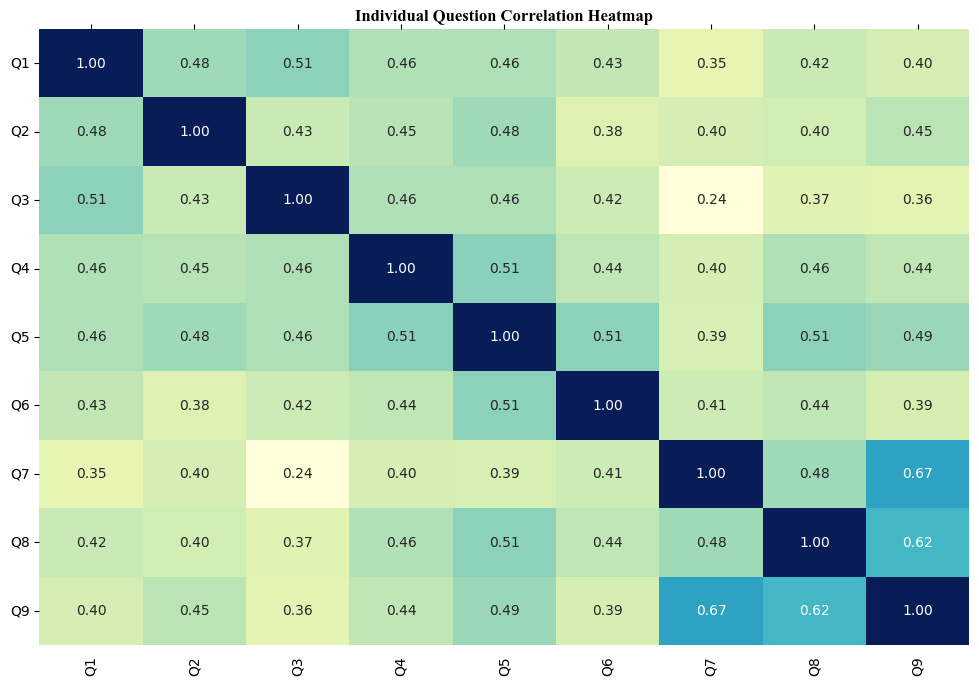

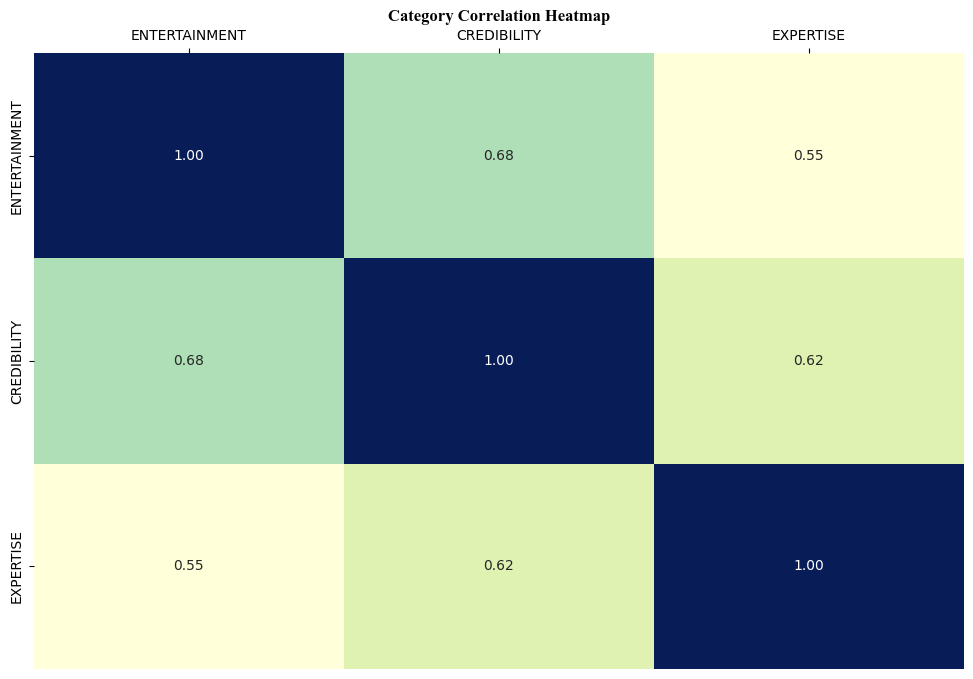

In [43]:
if __name__ == "__main__":
    main()